In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=200 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-8],]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((t_len,2,55,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,5))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (1000, 2)
Dimension - airfoil coordinates:  (2000, 50)
Dimension - coord with flaps:  (2000, 5)
Dimension - total coordinates:  (2000, 55)
Dimension - x_time:  (1000, 1)
Dimension - x_coordinates:  (1000, 2, 55, 1)
Dimension - y:  (1000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,55,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer')(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 200)   1000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 200)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 5400)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230102\\Case15"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230102unsteady_AeroCNN1_Case15_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 10s - loss: 0.2285 - rmse: 0.4778
Epoch 1: val_loss improved from inf to 0.21426, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 6s 199ms/step - loss: 0.2204 - rmse: 0.4693 - val_loss: 0.2143 - val_rmse: 0.4627 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1643 - rmse: 0.4052
Epoch 2: val_loss improved from 0.21426 to 0.20497, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 62ms/step - loss: 0.1891 - rmse: 0.4347 - val_loss: 0.2050 - val_rmse: 0.4526 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1999 - rmse: 0.4469
Epoch 3: val_loss improved from 0.20497 to 0.19411, saving model to D

3/3 [==============================] - 0s 83ms/step - loss: 0.0605 - rmse: 0.2456 - val_loss: 0.0627 - val_rmse: 0.2501 - lr: 1.0000e-04
Epoch 24/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0659 - rmse: 0.2564
Epoch 24: val_loss improved from 0.06268 to 0.06262, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 90ms/step - loss: 0.0602 - rmse: 0.2451 - val_loss: 0.0626 - val_rmse: 0.2499 - lr: 1.0000e-04
Epoch 25/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0553 - rmse: 0.2349
Epoch 25: val_loss did not improve from 0.06262
3/3 [==============================] - 0s 32ms/step - loss: 0.0599 - rmse: 0.2445 - val_loss: 0.0627 - val_rmse: 0.2502 - lr: 1.0000e-04
Epoch 26/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2304
Epoch 26: val_loss did not improve from 0.06262
3/3 [==================

Epoch 45/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0568 - rmse: 0.2379
Epoch 45: val_loss did not improve from 0.06197
3/3 [==============================] - 0s 30ms/step - loss: 0.0574 - rmse: 0.2392 - val_loss: 0.0621 - val_rmse: 0.2488 - lr: 1.0000e-04
Epoch 46/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0657 - rmse: 0.2561
Epoch 46: val_loss did not improve from 0.06197
3/3 [==============================] - 0s 29ms/step - loss: 0.0640 - rmse: 0.2526 - val_loss: 0.0620 - val_rmse: 0.2487 - lr: 1.0000e-04
Epoch 47/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0452 - rmse: 0.2123
Epoch 47: val_loss improved from 0.06197 to 0.06191, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 106ms/step - loss: 0.0539 - rmse: 0.2319 - val_loss: 0.0619 - val_rmse: 0.2485 - lr: 1.0000e-04
Epoch 48/10000
1/3 [==

Epoch 66/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0456 - rmse: 0.2132
Epoch 66: val_loss improved from 0.06080 to 0.06063, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 82ms/step - loss: 0.0570 - rmse: 0.2384 - val_loss: 0.0606 - val_rmse: 0.2459 - lr: 1.0000e-04
Epoch 67/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2343
Epoch 67: val_loss improved from 0.06063 to 0.06052, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 91ms/step - loss: 0.0557 - rmse: 0.2358 - val_loss: 0.0605 - val_rmse: 0.2457 - lr: 1.0000e-04
Epoch 68/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0553 - rmse: 0.2348
Epoch 68: val_loss improved from 0.06052 to 0.06045, saving mo

Epoch 87/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0546 - rmse: 0.2333
Epoch 87: val_loss improved from 0.05774 to 0.05698, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 83ms/step - loss: 0.0547 - rmse: 0.2335 - val_loss: 0.0570 - val_rmse: 0.2384 - lr: 1.0000e-04
Epoch 88/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2344
Epoch 88: val_loss improved from 0.05698 to 0.05672, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 74ms/step - loss: 0.0539 - rmse: 0.2319 - val_loss: 0.0567 - val_rmse: 0.2379 - lr: 1.0000e-04
Epoch 89/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0538 - rmse: 0.2315
Epoch 89: val_loss improved from 0.05672 to 0.05637, saving mo

3/3 [==============================] - 0s 77ms/step - loss: 0.0466 - rmse: 0.2155 - val_loss: 0.0479 - val_rmse: 0.2184 - lr: 1.0000e-04
Epoch 107/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0504 - rmse: 0.2241
Epoch 107: val_loss improved from 0.04786 to 0.04732, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 85ms/step - loss: 0.0476 - rmse: 0.2177 - val_loss: 0.0473 - val_rmse: 0.2172 - lr: 1.0000e-04
Epoch 108/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0452 - rmse: 0.2122
Epoch 108: val_loss improved from 0.04732 to 0.04709, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 83ms/step - loss: 0.0445 - rmse: 0.2106 - val_loss: 0.0471 - val_rmse: 0.2167 - lr: 1.0000e-04
Epoch 109/100

3/3 [==============================] - 0s 89ms/step - loss: 0.0319 - rmse: 0.1783 - val_loss: 0.0324 - val_rmse: 0.1795 - lr: 1.0000e-04
Epoch 127/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0273 - rmse: 0.1649
Epoch 127: val_loss improved from 0.03237 to 0.03188, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 103ms/step - loss: 0.0326 - rmse: 0.1801 - val_loss: 0.0319 - val_rmse: 0.1781 - lr: 1.0000e-04
Epoch 128/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - rmse: 0.1826
Epoch 128: val_loss improved from 0.03188 to 0.03046, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 86ms/step - loss: 0.0309 - rmse: 0.1753 - val_loss: 0.0305 - val_rmse: 0.1741 - lr: 1.0000e-04
Epoch 129/10

Epoch 146/10000
3/3 [==============================] - ETA: 0s - loss: 0.0107 - rmse: 0.1028
Epoch 146: val_loss improved from 0.01102 to 0.00978, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 111ms/step - loss: 0.0107 - rmse: 0.1028 - val_loss: 0.0098 - val_rmse: 0.0981 - lr: 1.0000e-04
Epoch 147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0924
Epoch 147: val_loss improved from 0.00978 to 0.00921, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 86ms/step - loss: 0.0091 - rmse: 0.0948 - val_loss: 0.0092 - val_rmse: 0.0952 - lr: 1.0000e-04
Epoch 148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0899
Epoch 148: val_loss improved from 0.00921 to 0.00775, sa

3/3 [==============================] - 0s 88ms/step - loss: 0.0022 - rmse: 0.0458 - val_loss: 0.0024 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0466
Epoch 168: val_loss improved from 0.00238 to 0.00227, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 83ms/step - loss: 0.0024 - rmse: 0.0472 - val_loss: 0.0023 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0400
Epoch 169: val_loss did not improve from 0.00227
3/3 [==============================] - 0s 40ms/step - loss: 0.0024 - rmse: 0.0476 - val_loss: 0.0024 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 170/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0438
Epoch 170: val_loss improved from 0.00227 to 0.00222, saving model

Epoch 191/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0355
Epoch 191: val_loss did not improve from 0.00172
3/3 [==============================] - 0s 28ms/step - loss: 0.0017 - rmse: 0.0389 - val_loss: 0.0018 - val_rmse: 0.0404 - lr: 1.0000e-04
Epoch 192/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0393
Epoch 192: val_loss did not improve from 0.00172
3/3 [==============================] - 0s 28ms/step - loss: 0.0018 - rmse: 0.0403 - val_loss: 0.0019 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 193/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0413
Epoch 193: val_loss did not improve from 0.00172
3/3 [==============================] - 0s 29ms/step - loss: 0.0018 - rmse: 0.0408 - val_loss: 0.0018 - val_rmse: 0.0408 - lr: 1.0000e-04
Epoch 194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0395
Epoch 194: val_loss did not improve from 0.00172
3/3 [================

Epoch 217/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0408
Epoch 217: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 30ms/step - loss: 0.0016 - rmse: 0.0378 - val_loss: 0.0015 - val_rmse: 0.0371 - lr: 1.0000e-04
Epoch 218/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0423
Epoch 218: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 30ms/step - loss: 0.0015 - rmse: 0.0371 - val_loss: 0.0015 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 219/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0405
Epoch 219: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 28ms/step - loss: 0.0016 - rmse: 0.0379 - val_loss: 0.0015 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 220/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0339
Epoch 220: val_loss did not improve from 0.00144
3/3 [================

Epoch 241/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0346
Epoch 241: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 30ms/step - loss: 0.0013 - rmse: 0.0333 - val_loss: 0.0012 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 242/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0347
Epoch 242: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 31ms/step - loss: 0.0013 - rmse: 0.0338 - val_loss: 0.0013 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 243/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0304
Epoch 243: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 28ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 0.0013 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 244/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0393
Epoch 244: val_loss did not improve from 0.00119
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 9.8846e-04 - rmse: 0.0290
Epoch 268: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 29ms/step - loss: 0.0011 - rmse: 0.0310 - val_loss: 0.0011 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 269/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0304
Epoch 269: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 29ms/step - loss: 0.0011 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 270/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9955e-04 - rmse: 0.0256
Epoch 270: val_loss did not improve from 0.00105
3/3 [==============================] - 0s 29ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 271/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3131e-04 - rmse: 0.0220
Epoch 271: val_loss improved from 0.00105 to 0.00101, saving model to D:\T

3/3 [==============================] - 0s 28ms/step - loss: 8.3189e-04 - rmse: 0.0262 - val_loss: 8.8783e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 293/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5853e-04 - rmse: 0.0267
Epoch 293: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 29ms/step - loss: 8.9517e-04 - rmse: 0.0274 - val_loss: 8.8647e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 294/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3179e-04 - rmse: 0.0242
Epoch 294: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 29ms/step - loss: 8.7591e-04 - rmse: 0.0270 - val_loss: 8.6952e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 295/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5684e-04 - rmse: 0.0267
Epoch 295: val_loss improved from 0.00087 to 0.00083, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256u

1/3 [=========>....................] - ETA: 0s - loss: 6.7610e-04 - rmse: 0.0231
Epoch 317: val_loss improved from 0.00072 to 0.00072, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 80ms/step - loss: 6.9246e-04 - rmse: 0.0234 - val_loss: 7.1945e-04 - val_rmse: 0.0240 - lr: 1.0000e-04
Epoch 318/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7802e-04 - rmse: 0.0289
Epoch 318: val_loss improved from 0.00072 to 0.00071, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 97ms/step - loss: 6.7724e-04 - rmse: 0.0231 - val_loss: 7.0621e-04 - val_rmse: 0.0237 - lr: 1.0000e-04
Epoch 319/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0494e-04 - rmse: 0.0276
Epoch 319: val_loss did not improve from 0.00

Epoch 341/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4723e-04 - rmse: 0.0201
Epoch 341: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 29ms/step - loss: 5.8935e-04 - rmse: 0.0211 - val_loss: 5.7906e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 342/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4143e-04 - rmse: 0.0200
Epoch 342: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 29ms/step - loss: 6.0952e-04 - rmse: 0.0216 - val_loss: 6.2019e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 343/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4128e-04 - rmse: 0.0200
Epoch 343: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 28ms/step - loss: 5.4225e-04 - rmse: 0.0200 - val_loss: 5.7488e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 344/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8259e-04 - rmse: 0.0232
Epoch 344: val_loss improved f

Epoch 367/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3181e-04 - rmse: 0.0197
Epoch 367: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 27ms/step - loss: 5.1790e-04 - rmse: 0.0194 - val_loss: 4.9472e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 368/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4793e-04 - rmse: 0.0175
Epoch 368: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 27ms/step - loss: 5.0449e-04 - rmse: 0.0190 - val_loss: 5.5784e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 369/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4422e-04 - rmse: 0.0224
Epoch 369: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 29ms/step - loss: 5.1724e-04 - rmse: 0.0194 - val_loss: 5.3804e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 370/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8972e-04 - rmse: 0.0186
Epoch 370: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 3.8216e-04 - rmse: 0.0155
Epoch 392: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 29ms/step - loss: 4.3061e-04 - rmse: 0.0170 - val_loss: 4.3563e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 393/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9182e-04 - rmse: 0.0158
Epoch 393: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 28ms/step - loss: 4.1562e-04 - rmse: 0.0166 - val_loss: 4.4003e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 394/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4673e-04 - rmse: 0.0175
Epoch 394: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 29ms/step - loss: 4.1440e-04 - rmse: 0.0165 - val_loss: 3.9481e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 395/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7193e-04 - rmse: 0.0152
Epoch 395: val_loss improved from 0.00039 to 0

1/3 [=========>....................] - ETA: 0s - loss: 3.0125e-04 - rmse: 0.0127
Epoch 418: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 29ms/step - loss: 3.1386e-04 - rmse: 0.0132 - val_loss: 3.3483e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 419/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3451e-04 - rmse: 0.0139
Epoch 419: val_loss improved from 0.00033 to 0.00031, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 82ms/step - loss: 3.4016e-04 - rmse: 0.0141 - val_loss: 3.1488e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 420/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0659e-04 - rmse: 0.0129
Epoch 420: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 29ms/step - loss: 3.2338e-04 - rmse: 0.0135 - val_loss: 3.2016e-04 - val_rmse: 0.0134 - lr: 1.0000e-

Epoch 444/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0472e-04 - rmse: 0.0129
Epoch 444: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 27ms/step - loss: 2.8278e-04 - rmse: 0.0120 - val_loss: 2.7500e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 445/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0604e-04 - rmse: 0.0129
Epoch 445: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 30ms/step - loss: 2.8322e-04 - rmse: 0.0120 - val_loss: 2.7700e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 446/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4022e-04 - rmse: 0.0100
Epoch 446: val_loss improved from 0.00027 to 0.00027, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 113ms/step - loss: 2.7803e-04 - rmse: 0.0118 - val_loss: 2.6653e-04 - val_rmse: 0.01

3/3 [==============================] - 0s 75ms/step - loss: 2.7100e-04 - rmse: 0.0115 - val_loss: 2.5139e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 470/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4192e-04 - rmse: 0.0102
Epoch 470: val_loss improved from 0.00025 to 0.00025, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 76ms/step - loss: 2.6581e-04 - rmse: 0.0113 - val_loss: 2.4837e-04 - val_rmse: 0.0105 - lr: 1.0000e-04
Epoch 471/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4061e-04 - rmse: 0.0101
Epoch 471: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 27ms/step - loss: 2.4797e-04 - rmse: 0.0105 - val_loss: 2.5329e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 472/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3553e-04 - rmse: 0.0099
Epoch 472: val_loss did not im

Epoch 496/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.6393e-04 - rmse: 0.0113
Epoch 496: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 27ms/step - loss: 2.7079e-04 - rmse: 0.0116 - val_loss: 2.4101e-04 - val_rmse: 0.0102 - lr: 1.0000e-04
Epoch 497/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4771e-04 - rmse: 0.0105
Epoch 497: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 28ms/step - loss: 2.8004e-04 - rmse: 0.0119 - val_loss: 3.0186e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 498/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6743e-04 - rmse: 0.0152
Epoch 498: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 29ms/step - loss: 2.8151e-04 - rmse: 0.0120 - val_loss: 2.5177e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 499/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7640e-04 - rmse: 0.0118
Epoch 499: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 2.2848e-04 - rmse: 0.0096
Epoch 523: val_loss improved from 0.00022 to 0.00021, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 74ms/step - loss: 2.4179e-04 - rmse: 0.0103 - val_loss: 2.0951e-04 - val_rmse: 0.0086 - lr: 1.0000e-04
Epoch 524/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0871e-04 - rmse: 0.0085
Epoch 524: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 28ms/step - loss: 2.3770e-04 - rmse: 0.0101 - val_loss: 2.4292e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 525/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3661e-04 - rmse: 0.0100
Epoch 525: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 28ms/step - loss: 2.4204e-04 - rmse: 0.0103 - val_loss: 2.7254e-04 - val_rmse: 0.0117 - lr: 1.0000e-

Epoch 550/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9043e-04 - rmse: 0.0074
Epoch 550: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 27ms/step - loss: 2.1022e-04 - rmse: 0.0087 - val_loss: 2.3266e-04 - val_rmse: 0.0099 - lr: 1.0000e-04
Epoch 551/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2855e-04 - rmse: 0.0097
Epoch 551: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 21ms/step - loss: 2.3683e-04 - rmse: 0.0101 - val_loss: 2.5673e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 552/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4313e-04 - rmse: 0.0104
Epoch 552: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 20ms/step - loss: 2.2716e-04 - rmse: 0.0096 - val_loss: 2.6055e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 553/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7060e-04 - rmse: 0.0116
Epoch 553: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 2.1749e-04 - rmse: 0.0091
Epoch 577: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 21ms/step - loss: 2.0682e-04 - rmse: 0.0085 - val_loss: 2.2226e-04 - val_rmse: 0.0094 - lr: 1.0000e-04
Epoch 578/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0073e-04 - rmse: 0.0082
Epoch 578: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 75ms/step - loss: 2.2336e-04 - rmse: 0.0095 - val_loss: 1.9509e-04 - val_rmse: 0.0078 - lr: 1.0000e-04
Epoch 579/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1889e-04 - rmse: 0.0092
Epoch 579: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 19ms/step - loss: 2.1550e-04 - rmse: 0.0090 - val_loss: 2.4369e-04 - val_rmse: 0.0105 - lr: 1.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 2.3180e-04 - rmse: 0.0099
Epoch 604: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 27ms/step - loss: 2.3288e-04 - rmse: 0.0100 - val_loss: 2.7782e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 605/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5466e-04 - rmse: 0.0110
Epoch 605: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 28ms/step - loss: 2.4738e-04 - rmse: 0.0107 - val_loss: 2.0021e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 606/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8460e-04 - rmse: 0.0072
Epoch 606: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 29ms/step - loss: 2.1334e-04 - rmse: 0.0090 - val_loss: 2.1750e-04 - val_rmse: 0.0092 - lr: 1.0000e-04
Epoch 607/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1634e-04 - rmse: 0.0091
Epoch 607: val_loss did not improve from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 1.9218e-04 - rmse: 0.0078
Epoch 631: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 27ms/step - loss: 2.0182e-04 - rmse: 0.0084 - val_loss: 2.1696e-04 - val_rmse: 0.0092 - lr: 1.0000e-04
Epoch 632/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1045e-04 - rmse: 0.0089
Epoch 632: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 27ms/step - loss: 1.9462e-04 - rmse: 0.0079 - val_loss: 1.9865e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 633/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1083e-04 - rmse: 0.0089
Epoch 633: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 78ms/step - loss: 1.9622e-04 - rmse: 0.0080 - val_loss: 1.8699e-04 - val_rmse: 0.0074 - lr: 1.0000e-

1/3 [=========>....................] - ETA: 0s - loss: 1.8915e-04 - rmse: 0.0076
Epoch 658: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 29ms/step - loss: 2.0225e-04 - rmse: 0.0084 - val_loss: 1.8394e-04 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 659/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7663e-04 - rmse: 0.0068
Epoch 659: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 27ms/step - loss: 1.8340e-04 - rmse: 0.0072 - val_loss: 1.9705e-04 - val_rmse: 0.0081 - lr: 1.0000e-04
Epoch 660/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8382e-04 - rmse: 0.0073
Epoch 660: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 28ms/step - loss: 1.8808e-04 - rmse: 0.0076 - val_loss: 1.9561e-04 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 661/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0933e-04 - rmse: 0.0089
Epoch 661: val_loss did not improve from 0.000

Epoch 686/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8610e-04 - rmse: 0.0075
Epoch 686: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 29ms/step - loss: 1.9238e-04 - rmse: 0.0079 - val_loss: 2.0988e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 687/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9540e-04 - rmse: 0.0081
Epoch 687: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 27ms/step - loss: 1.9085e-04 - rmse: 0.0078 - val_loss: 1.8555e-04 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 688/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8511e-04 - rmse: 0.0074
Epoch 688: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 76ms/step - loss: 1.7938e-04 - rmse: 0.0070 - val_loss: 1.7956e-04 - val_rmse: 0.007

1/3 [=========>....................] - ETA: 0s - loss: 1.8412e-04 - rmse: 0.0074
Epoch 713: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 28ms/step - loss: 2.4127e-04 - rmse: 0.0106 - val_loss: 1.8136e-04 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 714/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7017e-04 - rmse: 0.0064
Epoch 714: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 28ms/step - loss: 2.4893e-04 - rmse: 0.0110 - val_loss: 2.3005e-04 - val_rmse: 0.0101 - lr: 1.0000e-04
Epoch 715/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1859e-04 - rmse: 0.0095
Epoch 715: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 28ms/step - loss: 2.3154e-04 - rmse: 0.0101 - val_loss: 2.5123e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 716/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4211e-04 - rmse: 0.0106
Epoch 716: val_loss did not improve from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 1.8634e-04 - rmse: 0.0077
Epoch 741: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 28ms/step - loss: 1.9161e-04 - rmse: 0.0080 - val_loss: 1.9520e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 742/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8202e-04 - rmse: 0.0074
Epoch 742: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 29ms/step - loss: 1.7693e-04 - rmse: 0.0070 - val_loss: 1.8676e-04 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 743/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8623e-04 - rmse: 0.0077
Epoch 743: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 27ms/step - loss: 1.8609e-04 - rmse: 0.0076 - val_loss: 1.7324e-04 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 744/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6401e-04 - rmse: 0.0060
Epoch 744: val_loss did not improve from 0.000

Epoch 768/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7393e-04 - rmse: 0.0069
Epoch 768: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 1.7751e-04 - rmse: 0.0071 - val_loss: 2.0829e-04 - val_rmse: 0.0090 - lr: 1.0000e-04
Epoch 769/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9975e-04 - rmse: 0.0085
Epoch 769: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 1.9226e-04 - rmse: 0.0081 - val_loss: 1.9676e-04 - val_rmse: 0.0084 - lr: 1.0000e-04
Epoch 770/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9682e-04 - rmse: 0.0084
Epoch 770: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 1.9374e-04 - rmse: 0.0082 - val_loss: 1.7356e-04 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 771/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7069e-04 - rmse: 0.0066
Epoch 771: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 1.7302e-04 - rmse: 0.0069
Epoch 796: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 27ms/step - loss: 1.7591e-04 - rmse: 0.0071 - val_loss: 1.9660e-04 - val_rmse: 0.0084 - lr: 1.0000e-04
Epoch 797/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0946e-04 - rmse: 0.0092
Epoch 797: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 29ms/step - loss: 1.8495e-04 - rmse: 0.0077 - val_loss: 1.8634e-04 - val_rmse: 0.0078 - lr: 1.0000e-04
Epoch 798/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8410e-04 - rmse: 0.0076
Epoch 798: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 28ms/step - loss: 1.7197e-04 - rmse: 0.0068 - val_loss: 1.8061e-04 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 799/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7935e-04 - rmse: 0.0073
Epoch 799: val_loss improved from 0.00016 to 0

Epoch 823/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7252e-04 - rmse: 0.0069
Epoch 823: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 27ms/step - loss: 1.8721e-04 - rmse: 0.0079 - val_loss: 1.6223e-04 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 824/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5564e-04 - rmse: 0.0056
Epoch 824: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 27ms/step - loss: 1.6295e-04 - rmse: 0.0062 - val_loss: 1.8961e-04 - val_rmse: 0.0081 - lr: 1.0000e-04
Epoch 825/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7774e-04 - rmse: 0.0073
Epoch 825: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 28ms/step - loss: 1.7457e-04 - rmse: 0.0071 - val_loss: 1.7782e-04 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 826/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8964e-04 - rmse: 0.0081
Epoch 826: val_loss did not im

3/3 [==============================] - 0s 29ms/step - loss: 1.6513e-04 - rmse: 0.0064 - val_loss: 1.5888e-04 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 851/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6094e-04 - rmse: 0.0061
Epoch 851: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 27ms/step - loss: 1.6156e-04 - rmse: 0.0061 - val_loss: 1.7302e-04 - val_rmse: 0.0070 - lr: 5.0000e-05
Epoch 852/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7034e-04 - rmse: 0.0068
Epoch 852: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 27ms/step - loss: 1.5971e-04 - rmse: 0.0060 - val_loss: 1.5981e-04 - val_rmse: 0.0060 - lr: 5.0000e-05
Epoch 853/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6112e-04 - rmse: 0.0061
Epoch 853: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 28ms/step - loss: 1.5811e-04 - rmse: 0.0059 - val_loss: 1.6075e-04 - val_rmse: 0.0061

1/3 [=========>....................] - ETA: 0s - loss: 1.4949e-04 - rmse: 0.0051
Epoch 877: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 29ms/step - loss: 1.5571e-04 - rmse: 0.0057 - val_loss: 1.5449e-04 - val_rmse: 0.0056 - lr: 5.0000e-05
Epoch 878/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4005e-04 - rmse: 0.0041
Epoch 878: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 28ms/step - loss: 1.5196e-04 - rmse: 0.0054 - val_loss: 1.5418e-04 - val_rmse: 0.0056 - lr: 5.0000e-05
Epoch 879/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5056e-04 - rmse: 0.0052
Epoch 879: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 27ms/step - loss: 1.5035e-04 - rmse: 0.0052 - val_loss: 1.5393e-04 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 880/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5010e-04 - rmse: 0.0052
Epoch 880: val_loss did not improve from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 1.5532e-04 - rmse: 0.0057
Epoch 904: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 28ms/step - loss: 1.5209e-04 - rmse: 0.0054 - val_loss: 1.5743e-04 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 905/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5603e-04 - rmse: 0.0058
Epoch 905: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 28ms/step - loss: 1.5559e-04 - rmse: 0.0057 - val_loss: 1.5343e-04 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 906/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4253e-04 - rmse: 0.0044
Epoch 906: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 28ms/step - loss: 1.5091e-04 - rmse: 0.0053 - val_loss: 1.5506e-04 - val_rmse: 0.0057 - lr: 5.0000e-05
Epoch 907/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5294e-04 - rmse: 0.0055
Epoch 907: val_loss did not improve from 0.000

Epoch 931/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4882e-04 - rmse: 0.0051
Epoch 931: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 27ms/step - loss: 1.5012e-04 - rmse: 0.0053 - val_loss: 1.5610e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 932/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5234e-04 - rmse: 0.0055
Epoch 932: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 27ms/step - loss: 1.5241e-04 - rmse: 0.0055 - val_loss: 1.6061e-04 - val_rmse: 0.0062 - lr: 5.0000e-05
Epoch 933/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5400e-04 - rmse: 0.0056
Epoch 933: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 28ms/step - loss: 1.5418e-04 - rmse: 0.0056 - val_loss: 1.5515e-04 - val_rmse: 0.0057 - lr: 5.0000e-05
Epoch 934/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5009e-04 - rmse: 0.0053
Epoch 934: val_loss did not im

Epoch 958/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4666e-04 - rmse: 0.0050
Epoch 958: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 87ms/step - loss: 1.5108e-04 - rmse: 0.0054 - val_loss: 1.4939e-04 - val_rmse: 0.0052 - lr: 2.5000e-05
Epoch 959/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4356e-04 - rmse: 0.0046
Epoch 959: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 27ms/step - loss: 1.4430e-04 - rmse: 0.0047 - val_loss: 1.4980e-04 - val_rmse: 0.0053 - lr: 2.5000e-05
Epoch 960/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5476e-04 - rmse: 0.0057
Epoch 960: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 27ms/step - loss: 1.4878e-04 - rmse: 0.0052 - val_loss: 1.5047e-04 - val_rmse: 0.005

1/3 [=========>....................] - ETA: 0s - loss: 1.4731e-04 - rmse: 0.0051
Epoch 984: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 27ms/step - loss: 1.5176e-04 - rmse: 0.0055 - val_loss: 1.5025e-04 - val_rmse: 0.0053 - lr: 2.5000e-05
Epoch 985/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5069e-04 - rmse: 0.0054
Epoch 985: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 28ms/step - loss: 1.4902e-04 - rmse: 0.0052 - val_loss: 1.4910e-04 - val_rmse: 0.0052 - lr: 2.5000e-05
Epoch 986/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4435e-04 - rmse: 0.0048
Epoch 986: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 29ms/step - loss: 1.4716e-04 - rmse: 0.0050 - val_loss: 1.5040e-04 - val_rmse: 0.0054 - lr: 2.5000e-05
Epoch 987/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4628e-04 - rmse: 0.0050
Epoch 987: val_loss improved from 0.00015 to 0

1/3 [=========>....................] - ETA: 0s - loss: 1.4617e-04 - rmse: 0.0050
Epoch 1010: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 29ms/step - loss: 1.4444e-04 - rmse: 0.0048 - val_loss: 1.4889e-04 - val_rmse: 0.0052 - lr: 2.5000e-05
Epoch 1011/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4791e-04 - rmse: 0.0051
Epoch 1011: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 27ms/step - loss: 1.5031e-04 - rmse: 0.0054 - val_loss: 1.4847e-04 - val_rmse: 0.0052 - lr: 2.5000e-05
Epoch 1012/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4784e-04 - rmse: 0.0051
Epoch 1012: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 27ms/step - loss: 1.4588e-04 - rmse: 0.0049 - val_loss: 1.4861e-04 - val_rmse: 0.0052 - lr: 2.5000e-05
Epoch 1013/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4421e-04 - rmse: 0.0048
Epoch 1013: val_loss did not improve fro

Epoch 1037/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5144e-04 - rmse: 0.0055
Epoch 1037: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 28ms/step - loss: 1.4649e-04 - rmse: 0.0050 - val_loss: 1.4886e-04 - val_rmse: 0.0053 - lr: 2.5000e-05
Epoch 1038/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4674e-04 - rmse: 0.0050
Epoch 1038: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 28ms/step - loss: 1.4641e-04 - rmse: 0.0050 - val_loss: 1.4764e-04 - val_rmse: 0.0051 - lr: 2.5000e-05
Epoch 1039/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4704e-04 - rmse: 0.0051
Epoch 1039: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 27ms/step - loss: 1.4519e-04 - rmse: 0.0049 - val_loss: 1.4774e-04 - val_rmse: 0.0051 - lr: 2.5000e-05
Epoch 1040/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5234e-04 - rmse: 0.0056
Epoch 1040: val_loss di

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:01:52.896947


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230102_AeroCNN1_Case13_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

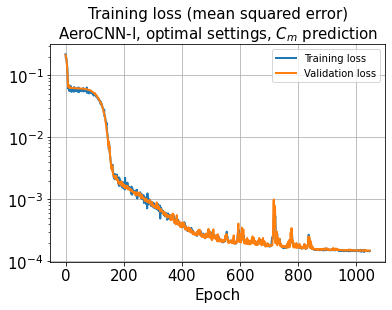

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

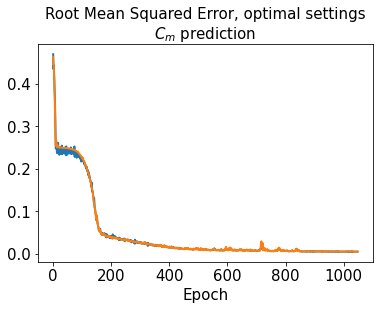

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

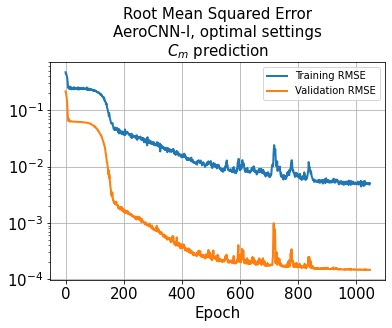

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

22/22 [==============================] - 0s 8ms/step - loss: 1.5596e-04 - rmse: 0.0057


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

7/7 [==============================] - 0s 8ms/step - loss: 1.5704e-04 - rmse: 0.0058


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

4/4 [==============================] - 0s 11ms/step - loss: 1.5514e-04 - rmse: 0.0056


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

4/4 [==============================] - 0s 2ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.012284900653642003
0.4967495731959914


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.012260955203812802
0.48135712914146367


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.012316242180031516
0.5085792850960973


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230102"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230unsteady_AeroCNN1_Case15_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

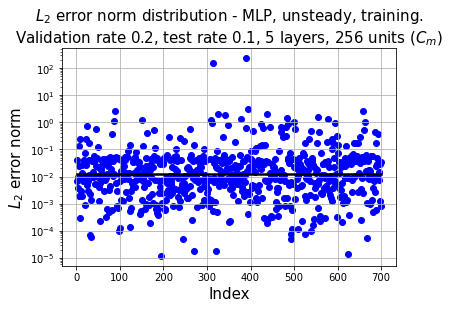

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

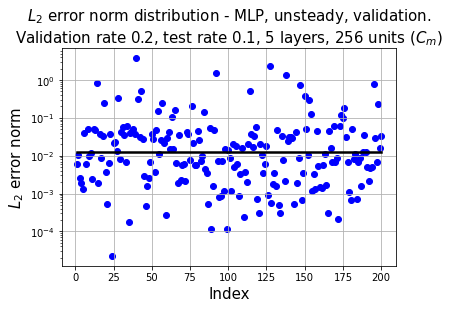

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

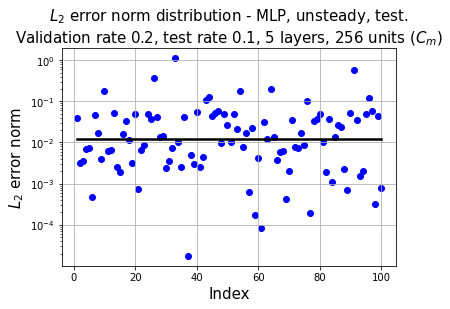

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

32/32 [==============================] - 0s 3ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([1.000313], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.012282986695125005


In [67]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [72]:
t

array([[10.   ],
       [10.001],
       [10.002],
       [10.003],
       [10.004],
       [10.005],
       [10.006],
       [10.007],
       [10.008],
       [10.009],
       [10.01 ],
       [10.011],
       [10.012],
       [10.013],
       [10.014],
       [10.015],
       [10.016],
       [10.017],
       [10.018],
       [10.019],
       [10.02 ],
       [10.021],
       [10.022],
       [10.023],
       [10.024],
       [10.025],
       [10.026],
       [10.027],
       [10.028],
       [10.029],
       [10.03 ],
       [10.031],
       [10.032],
       [10.033],
       [10.034],
       [10.035],
       [10.036],
       [10.037],
       [10.038],
       [10.039],
       [10.04 ],
       [10.041],
       [10.042],
       [10.043],
       [10.044],
       [10.045],
       [10.046],
       [10.047],
       [10.048],
       [10.049],
       [10.05 ],
       [10.051],
       [10.052],
       [10.053],
       [10.054],
       [10.055],
       [10.056],
       [10.057],
       [10.058

In [73]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [70]:
x_time += 10

L2 error of Cm: 0.0123


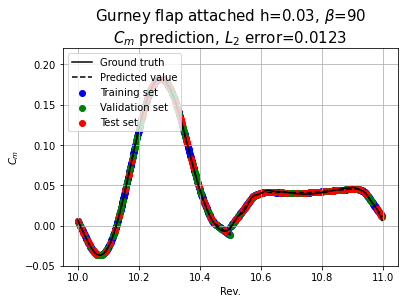

In [74]:
h = [0.03]
beta = [90]
for i in range(0,1):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [77]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0123


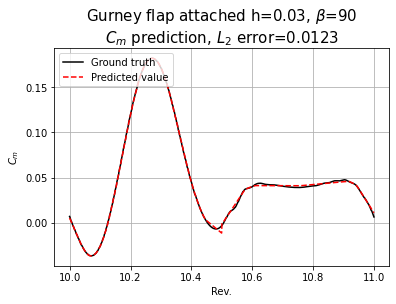

In [78]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0123


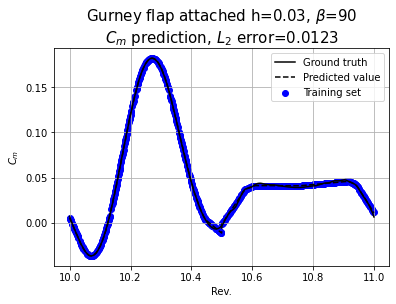

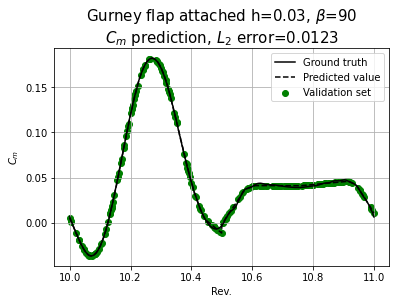

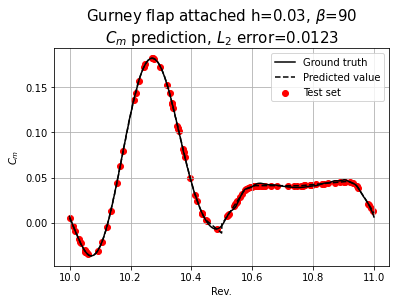

In [79]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

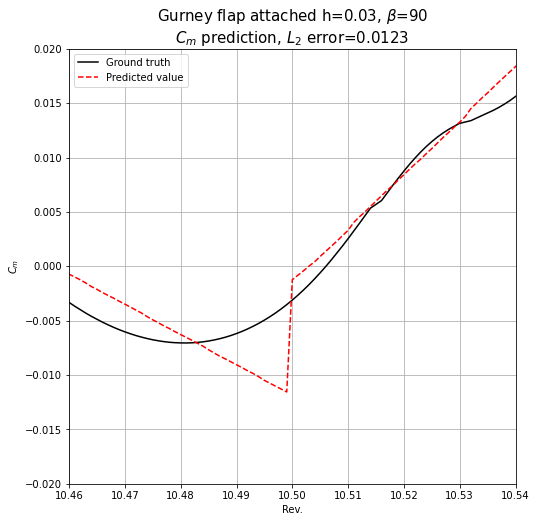

In [82]:
plt.figure(figsize=(8,8))
plt.plot(t, cm, 'k-', label='Ground truth')
plt.plot(t, denormalize(predicted), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
plt.xlim([10.46, 10.54])
plt.ylim([-0.02, 0.02])
plt.grid()
plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [85]:
t[499]

array([10.499])